# Вступ до напівкерованого навчання. Self-learning. Proxy Labelling. Noisy Student.


#Мета
Ознайомлення з загальним принципами напівкерованого навчання. Отримання навичок роботи з маркованими і немаркованими наборами даних. Отримання навичок побудови напівкерованих моделей но основі нейроних мереж.

# Завдання

1. Встановити сід генератору псевдовипадкових чисел;
2. Завантажити обраний набір даних;
3. Відобразити декілька зображень з набору даних у блокноті;
4. Розділити обраний набір даних на дві вибірки: тренувальну та валідаційну, співвідношення розміру вибірок обрати на власний розсуд. Після чого розділити тренувальний набір на дві частини марковану(30%) та немарковану(70%);
5. Завантажити та налаштувати нейронну мережу обраної архітектури;
6. Провести навчання нейронної мережі на початковому (до розділу на маркований і немаркований) тренувальному наборі даних. Вибір гіперпараметрів на власний розсуд. Побудувати графіки точності та loss мережі під час навчання;
7. Зберегти ваги навченої нейронної мережі у файл.
8. Провести навчання нейронної мережі напівкерованим алгоритмом використовуючи маркований і немаркований набір даних на 4 кроці. Вибір гіперпараметрів на власний розсуд. Побудувати графік точності моделі;
9. Зберегти ваги навченої нейронної мережі у файл.
10. Побудувати графіки точності та loss мережі під час навчання.
11. Зробити висновки, оформити звіт.


#Хід роботи

## 1. Виконання налаштування робочого середовища

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
torch.manual_seed(42)

## 2. Завантаження набору даних MNIST

In [ ]:
transform = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


100%|██████████| 9912422/9912422 [00:00<00:00, 58600919.06it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 47860803.57it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 18962142.01it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5753708.48it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## 3. Відобразимо декілька зображень з набору даних


In [ ]:
class_names = trainset.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

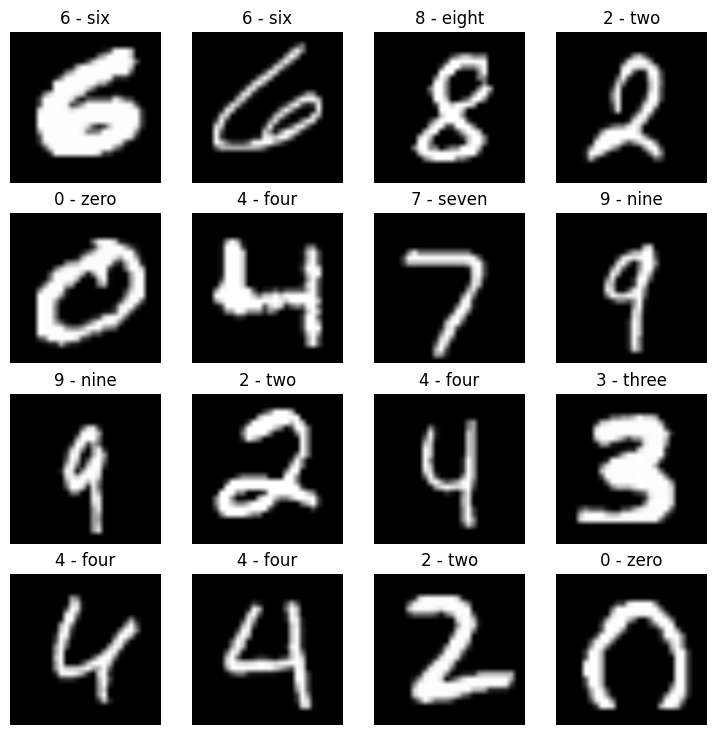

In [ ]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(trainset), size=[1]).item()
    img, label = trainset[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

## 4. Розділимо  набір даних на три вибірки: тренувальну, валідаційну та тестову

In [ ]:
# Divide the dataset into training, validation, and test sets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
full_train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size])

In [ ]:
label_data = int(0.3 * len(full_train_dataset))
unlabel_data = len(full_train_dataset) - label_data
label_dataset, unlabel_dataset = torch.utils.data.random_split(full_train_dataset, [label_data, unlabel_data])

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(full_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_dataloader = DataLoader(val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(testset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

label_dataloader = DataLoader(label_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

unlabel_dataloader = DataLoader(unlabel_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)


print(f"Full train images: {len(train_dataloader) * BATCH_SIZE}")
print(f"Label images: {len(label_dataloader)* BATCH_SIZE}")
print(f"Unlabel images: {len(unlabel_dataloader)* BATCH_SIZE}")
print(f"Valid images: {len(valid_dataloader)* BATCH_SIZE}")
print(f"Test images: {len(test_dataloader)* BATCH_SIZE}")

Full train images: 48000
Label images: 14400
Unlabel images: 33600
Valid images: 12000
Test images: 10016


In [ ]:
class_counts = {i: 0 for i in range(10)}
for images, labels in label_dataloader:
    for label in labels:
        class_counts[label.item()] += 1

# Print the counts
for label, count in class_counts.items():
    print(f"Class {label}: {count} images")

Class 0: 1440 images
Class 1: 1632 images
Class 2: 1359 images
Class 3: 1444 images
Class 4: 1392 images
Class 5: 1287 images
Class 6: 1437 images
Class 7: 1550 images
Class 8: 1377 images
Class 9: 1482 images


## 5. Завантажимо та налаштуємо нейронну мережу

In [ ]:
# Download and configure model
import torchvision.models as models

model = models.alexnet(pretrained=False)
model.features[0] = nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2)
model.classifier[6]=nn.Linear(4096, len(class_names))
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## 6. Проведемо навчання нейронної мережі но  повному тренувальному наборі даних

In [ ]:
from typing import Dict, List

# Training loop
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          valid_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

  results = {"train_loss": [],
             "train_acc": [],
             "val_loss": [],
             "val_acc": []
             }

  for epoch in range(epochs):
      # Training
      model.train()
      running_loss = 0.0
      correct_train = 0
      total_train = 0

      for inputs, labels in tqdm(train_dataloader):
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = loss_fn(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

          _, predicted = torch.max(outputs.data, 1)
          total_train += labels.size(0)
          correct_train += (predicted == labels).sum().item()

      train_loss = running_loss / len(train_dataloader)
      train_acc = 100 * correct_train / total_train

      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)

      # Validation
      model.eval()
      running_loss = 0.0
      correct_val = 0
      total_val = 0

      with torch.no_grad():
          for inputs, labels in valid_dataloader:
              inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
              outputs = model(inputs)
              loss = loss_fn(outputs, labels)
              running_loss += loss.item()

              _, predicted = torch.max(outputs.data, 1)
              total_val += labels.size(0)
              correct_val += (predicted == labels).sum().item()

      val_loss = running_loss / len(valid_dataloader)
      val_acc = 100 * correct_val / total_val

      results["val_loss"].append(val_loss)
      results["val_acc"].append(val_acc)

      print(f"Epoch [{epoch + 1}/{epochs}] - "
            f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}% - "
            f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

  return results

In [ ]:
def plot_model(history):
  train_accs, val_accs, train_losses, val_losses = history
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history['train_acc'], label='Train')
  plt.plot(history['val_acc'], label='Validation')
  plt.title('Accuracy vs. Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history['train_loss'], label='Train')
  plt.plot(history['val_loss'], label='Validation')
  plt.title('Loss vs. Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

results = train(model=model,
                train_dataloader=train_dataloader,
                valid_dataloader=valid_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device)

100%|██████████| 1500/1500 [01:53<00:00, 13.24it/s]


Epoch [1/10] - Train Loss: 0.3033, Train Accuracy: 90.35% - Validation Loss: 0.1367, Validation Accuracy: 96.32%


100%|██████████| 1500/1500 [01:36<00:00, 15.57it/s]


Epoch [2/10] - Train Loss: 0.1302, Train Accuracy: 96.47% - Validation Loss: 0.0888, Validation Accuracy: 97.55%


100%|██████████| 1500/1500 [01:35<00:00, 15.66it/s]


Epoch [3/10] - Train Loss: 0.1031, Train Accuracy: 97.31% - Validation Loss: 0.0519, Validation Accuracy: 98.56%


100%|██████████| 1500/1500 [01:36<00:00, 15.49it/s]


Epoch [4/10] - Train Loss: 0.0914, Train Accuracy: 97.42% - Validation Loss: 0.0824, Validation Accuracy: 97.55%


100%|██████████| 1500/1500 [01:37<00:00, 15.45it/s]


Epoch [5/10] - Train Loss: 0.0804, Train Accuracy: 97.84% - Validation Loss: 0.0552, Validation Accuracy: 98.54%


100%|██████████| 1500/1500 [01:35<00:00, 15.71it/s]


Epoch [6/10] - Train Loss: 0.0801, Train Accuracy: 97.91% - Validation Loss: 0.0596, Validation Accuracy: 98.33%


100%|██████████| 1500/1500 [01:34<00:00, 15.93it/s]


Epoch [7/10] - Train Loss: 0.0744, Train Accuracy: 97.97% - Validation Loss: 0.0503, Validation Accuracy: 98.75%


100%|██████████| 1500/1500 [01:33<00:00, 16.02it/s]


Epoch [8/10] - Train Loss: 0.0728, Train Accuracy: 98.07% - Validation Loss: 0.0630, Validation Accuracy: 98.27%


100%|██████████| 1500/1500 [01:33<00:00, 15.99it/s]


Epoch [9/10] - Train Loss: 0.0689, Train Accuracy: 98.11% - Validation Loss: 0.0605, Validation Accuracy: 98.33%


100%|██████████| 1500/1500 [01:36<00:00, 15.52it/s]


Epoch [10/10] - Train Loss: 0.0681, Train Accuracy: 98.15% - Validation Loss: 0.0559, Validation Accuracy: 98.33%


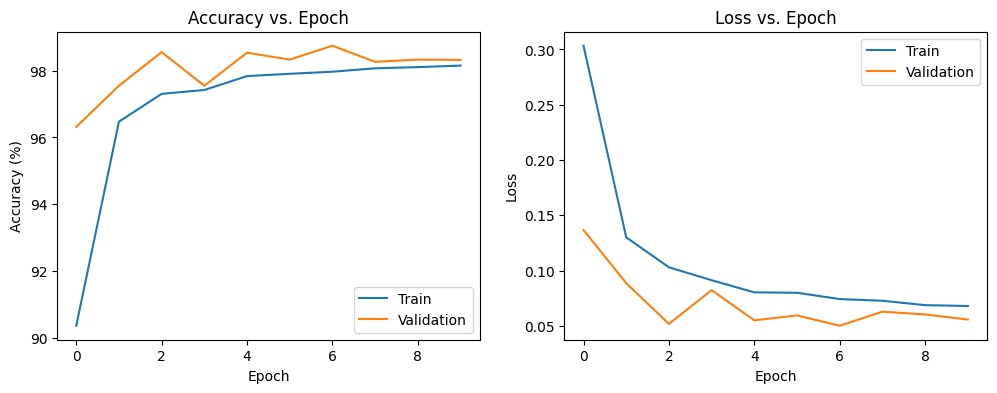

In [ ]:
plot_model(results)

## 7. Збережемо ваги навченої нейронної мережі у файл

In [ ]:
torch.save(model.state_dict(), 'full_data_train.pth')

## 8. Провести навчання нейронної мережі напівкерованим алгоритмом використовуючи маркований і немаркований набір даних на 4 кроці.

In [ ]:
ssl_model = models.alexnet(pretrained=False)
ssl_model.features[0] = nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2)
ssl_model.classifier[6]=nn.Linear(4096, len(class_names))
ssl_model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ssl_model.parameters(), lr=0.001)

results = train(model=ssl_model,
                train_dataloader=label_dataloader,
                valid_dataloader=valid_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 450/450 [00:30<00:00, 14.79it/s]


Epoch [1/10] - Train Loss: 0.7496, Train Accuracy: 73.99% - Validation Loss: 0.1853, Validation Accuracy: 94.38%


100%|██████████| 450/450 [00:29<00:00, 15.42it/s]


Epoch [2/10] - Train Loss: 0.2039, Train Accuracy: 94.09% - Validation Loss: 0.1362, Validation Accuracy: 95.75%


100%|██████████| 450/450 [00:32<00:00, 13.73it/s]


Epoch [3/10] - Train Loss: 0.1537, Train Accuracy: 95.39% - Validation Loss: 0.0981, Validation Accuracy: 97.12%


100%|██████████| 450/450 [00:28<00:00, 16.03it/s]


Epoch [4/10] - Train Loss: 0.1322, Train Accuracy: 96.11% - Validation Loss: 0.1045, Validation Accuracy: 96.77%


100%|██████████| 450/450 [00:28<00:00, 15.71it/s]


Epoch [5/10] - Train Loss: 0.1197, Train Accuracy: 96.51% - Validation Loss: 0.0966, Validation Accuracy: 97.30%


100%|██████████| 450/450 [00:27<00:00, 16.16it/s]


Epoch [6/10] - Train Loss: 0.1198, Train Accuracy: 96.60% - Validation Loss: 0.0849, Validation Accuracy: 97.78%


100%|██████████| 450/450 [00:28<00:00, 15.68it/s]


Epoch [7/10] - Train Loss: 0.0922, Train Accuracy: 97.42% - Validation Loss: 0.1488, Validation Accuracy: 96.25%


100%|██████████| 450/450 [00:27<00:00, 16.12it/s]


Epoch [8/10] - Train Loss: 0.0914, Train Accuracy: 97.28% - Validation Loss: 0.0831, Validation Accuracy: 97.56%


100%|██████████| 450/450 [00:28<00:00, 16.04it/s]


Epoch [9/10] - Train Loss: 0.0938, Train Accuracy: 97.45% - Validation Loss: 0.0891, Validation Accuracy: 97.47%


100%|██████████| 450/450 [00:27<00:00, 16.08it/s]


Epoch [10/10] - Train Loss: 0.0853, Train Accuracy: 97.52% - Validation Loss: 0.0774, Validation Accuracy: 97.85%


In [ ]:
pseudo_labels = []
total_train = 0
correct_train = 0

with torch.no_grad():
    for unlabeled_data, labels in unlabel_dataloader:
        unlabeled_data, labels = unlabeled_data.to(device), labels.to(device)
        outputs = ssl_model(unlabeled_data)

        _, predicted = torch.max(outputs.data, 1)
        pseudo_labels.extend(predicted.tolist())

        # accuracy measure
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

print('Accuracy', 100 * correct_train / total_train)

Accuracy 98.20535714285714


In [ ]:
# Define the custom dataset to include pseudo-labels
class CombineDataset(Dataset):
    def __init__(self, labeled_dataset, unlabeled_dataset, pseudo_labels):
        self.labeled_dataset = labeled_dataset
        self.unlabeled_dataset = unlabeled_dataset
        self.pseudo_labels = pseudo_labels

    def __len__(self):
        return len(self.labeled_dataset) + len(self.unlabeled_dataset)

    def __getitem__(self, index):
        if index < len(self.labeled_dataset):
            return self.labeled_dataset[index]
        else:
            # Adjust the index for the unlabeled data
            unlabeled_index = index - len(self.labeled_dataset)
            unlabeled_data, _ = self.unlabeled_dataset[unlabeled_index]
            pseudo_label = self.pseudo_labels[unlabeled_index]
            return unlabeled_data, pseudo_label


# Make sure pseudo_labels is ordered in the same way as unlabeled_dataset
# pseudo_labels = [pseudo_label_1, pseudo_label_2, ...]

# Concatenate the labeled and unlabeled data using the custom dataset
combined_dataset = CombineDataset(label_dataset, unlabel_dataset, pseudo_labels)

combined_dataloader = DataLoader(combined_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

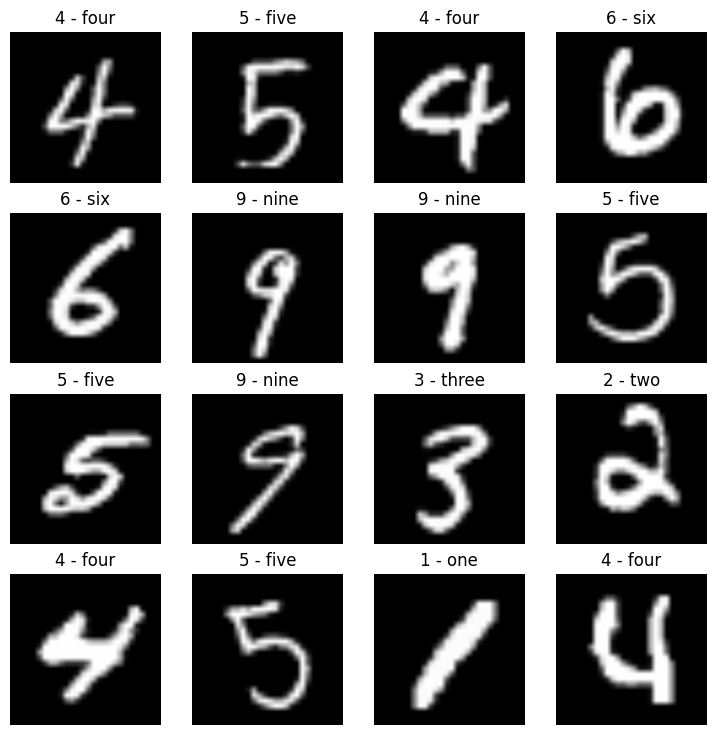

In [ ]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(combined_dataset), size=[1]).item()
    img, label = combined_dataset[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

In [ ]:
print(f"Combine images: {len(combined_dataloader)* BATCH_SIZE}")
print(f"Label images: {len(label_dataloader)* BATCH_SIZE}")
print(f"Unlabel images: {len(unlabel_dataloader)* BATCH_SIZE}")

Combine images: 48000
Label images: 14400
Unlabel images: 33600


In [ ]:
ssl_model_final = models.alexnet(pretrained=False)
ssl_model_final.features[0] = nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2)
ssl_model_final.classifier[6]=nn.Linear(4096, len(class_names))
ssl_model_final.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ssl_model_final.parameters(), lr=0.001)

results = train(model=ssl_model_final,
                train_dataloader=combined_dataloader,
                valid_dataloader=valid_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 1500/1500 [01:37<00:00, 15.32it/s]


Epoch [1/10] - Train Loss: 0.3773, Train Accuracy: 87.22% - Validation Loss: 0.0930, Validation Accuracy: 97.28%


100%|██████████| 1500/1500 [01:35<00:00, 15.65it/s]


Epoch [2/10] - Train Loss: 0.1303, Train Accuracy: 96.29% - Validation Loss: 0.0802, Validation Accuracy: 97.57%


100%|██████████| 1500/1500 [01:34<00:00, 15.91it/s]


Epoch [3/10] - Train Loss: 0.1196, Train Accuracy: 96.71% - Validation Loss: 0.0744, Validation Accuracy: 97.73%


100%|██████████| 1500/1500 [01:34<00:00, 15.91it/s]


Epoch [4/10] - Train Loss: 0.1066, Train Accuracy: 97.06% - Validation Loss: 0.0647, Validation Accuracy: 98.03%


100%|██████████| 1500/1500 [01:33<00:00, 16.02it/s]


Epoch [5/10] - Train Loss: 0.1024, Train Accuracy: 97.13% - Validation Loss: 0.0614, Validation Accuracy: 98.22%


100%|██████████| 1500/1500 [01:33<00:00, 16.04it/s]


Epoch [6/10] - Train Loss: 0.0971, Train Accuracy: 97.29% - Validation Loss: 0.0752, Validation Accuracy: 97.93%


100%|██████████| 1500/1500 [01:35<00:00, 15.69it/s]


Epoch [7/10] - Train Loss: 0.0974, Train Accuracy: 97.33% - Validation Loss: 0.0586, Validation Accuracy: 98.21%


100%|██████████| 1500/1500 [01:34<00:00, 15.80it/s]


Epoch [8/10] - Train Loss: 0.0930, Train Accuracy: 97.49% - Validation Loss: 0.0680, Validation Accuracy: 98.22%


100%|██████████| 1500/1500 [01:33<00:00, 16.06it/s]


Epoch [9/10] - Train Loss: 0.0838, Train Accuracy: 97.64% - Validation Loss: 0.0723, Validation Accuracy: 98.04%


100%|██████████| 1500/1500 [01:33<00:00, 16.01it/s]


Epoch [10/10] - Train Loss: 0.0898, Train Accuracy: 97.64% - Validation Loss: 0.0657, Validation Accuracy: 98.21%


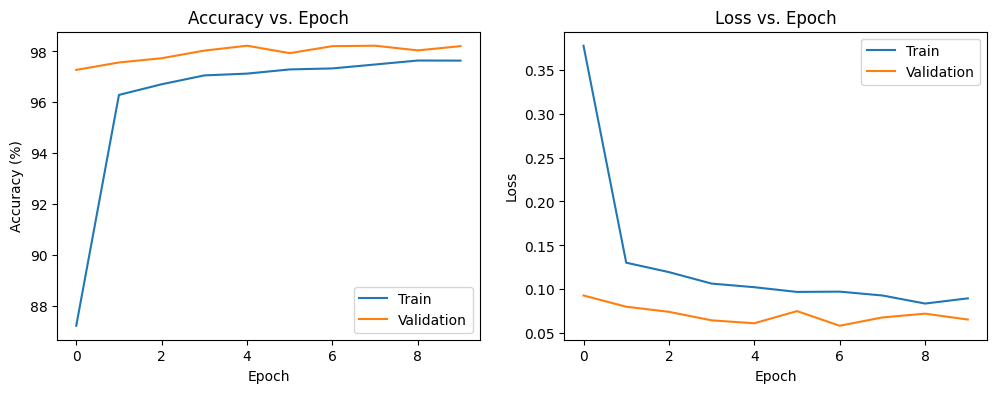

In [ ]:
plot_model(results)

# Висновок


У цій роботі ми досліджували концепцію напівконтрольованого навчання, потужного підходу до машинного навчання, який використовує як позначені, так і немарковані дані для навчання моделі. Ми використали архітектуру AlexNet як репрезентативну модель і навчили її в напівконтрольованому середовищі з використанням позначених і не позначених даних.

Ми створили спеціальний набір даних, який поєднує дані з мітками, дані без міток і відповідні їм псевдомітки, що дозволяє нам навчати модель за допомогою цього комбінованого набору даних. Після об’єднання цих наборів даних виконуємо донавчання моделі.

Аналіз результатів показав, що при навчанні на повному наборі даних модель показала точність в 98.33%, а при напівконтролюованому навчанні точність в 98.21%.

Підсумовуючи, напівконтрольоване навчання є ефективним засобом максимального використання доступних даних, використовуючи як марковані, так і немарковані дані. Він демонструє потенціал для підвищення продуктивності моделі та зменшення залежності від великих наборів даних із мітками, що робить його цінним інструментом для практичних програм машинного навчання.